<h2>Histogram of oriented gradients (H.O.G.) and SVM Image Classification with OpenCV and <a href="https://vision.skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01"> Computer Vision Learning Studio (CV Studio)</a></h2></h2>
<h3>Training Run: Train SVM image classifier</h3>

Created on JupyterLab

## Objectives


We will be classifying images using <code>Sklearn</code> and <a href="https://vision.skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01"> Computer Vision Learning Studio (CV Studio)</a>. CV Studio is a fast, easy and collaborative open-source Computer Vision tool for teams and individuals. You can upload your datasets and label them yourself. If you created a separate folder for each image class, the tool will do the labeling for you. H.O.G. combined with SVM was one of the ways image classification was done before more advanced methods like Deep Learning became popular.


<ul>
    <li>This tool contains the following sections:
        <ul>
            <li>Import Libraries</li>
            <li>Image Files and Paths  </li>
            <li>Plotting an Image </li>
            <li>H.O.G. as a feature descriptor </li>
            <li>SVM for Image classification </li>
            <li>Save your model to CVStudio</li>
            <li>What's Next</li>
        </ul>
    </li>
</ul>


***


## Import Important Libraries and Define Auxilary Functions


Libraries for data processing and visualization:


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

Libraries for image pre-processing and classification:


In [2]:
import cv2
from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

Libraries for OS and Cloud:


In [3]:
import os
from skillsnetwork import cvstudio

We will load and process every image. Let's go over some concepts:

<ul>
        <ul>
            <li><code>cv2.resize()</code> to resize the image </li>
            <li><code>cv2.COLOR_BGR2GRAY()</code> will convert the images to greyscale image</li>
            <li><code>hog()</code> will get the H.O.G. features from the image </li>
        </ul>

</ul>

We will use this function to read and preprocess the images, the function will be explained in the **Histogram of Oriented Gradients (H.O.G.)** section.

**H.O.G., is one of many types of features that have been developed over the years. The technique counts occurrences of gradient orientation in localized portions of an image. Gradients describe the tendency of intensity along the axis. HOG would generate a Histogram for each of these regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’.**

**General (H.O.G.) is calculated as follows: assuming we have an image of a kitten. We will convert the image to grayscale, we calculate the magnitude and angles of the gradients using Sobel (the Horizontal changes or gradient are computed by convolving the image with a kernel).**

**The images are divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled.**

**To improve imbalance to highlights and shadows in the image, cells are block normalized. The HOG feature vector is a combination of all pixel-level histograms and used with SVM to classify the image.**

In [4]:
def load_images(image_paths):
# loop over the input images
    for (i, image_path) in enumerate(image_paths):
        #read image
        image = cv2.imread(image_path)
        image = np.array(image).astype('uint8')
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_images = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        #label image using the annotations
        label = class_object.index(annotations["annotations"][image_path[7:]][0]['label'])
        train_images.append(hog_features)
        train_labels.append(label)

## Download Your Images and Annotations

We will train and classify them using the SVM classifier using the <code>Sklearn</code> library. Before we start, let's get the images and take a look at some of them.


In [5]:
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()

# Download All Images
cvstudioClient.downloadAll()

100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


Get the annotations from CV Studio:


In [6]:
annotations = cvstudioClient.get_annotations()

Let's view the format of the annotations we've just downloaded. The following code will display only the first 5 annotations. The annotations will come in a JSON file. What you can see is the image name as the key and dog as label object.


In [7]:
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five

{'06802f96-64d9-4f5d-be01-aeedeab774b6.jpg': [{'label': 'cat'}],
 'b0e095f0-e313-4607-b0da-7859d0875315.jpg': [{'label': 'dog'}],
 '33cd6519-1b81-4dea-8d20-d3d7de4a09e6.jpg': [{'label': 'dog'}],
 '240f8cc3-f229-4208-a67b-cca73d766116.jpg': [{'label': 'dog'}],
 'e9d8a877-0179-40d2-8120-a0cda6db7e68.jpg': [{'label': 'cat'}]}

## Histogram of Oriented Gradients (H.O.G.)


H.O.G. generates a histogram for each localized region. We will pick a random image and see how H.O.G. works.


In [8]:
sample_image = 'images/' + random.choice(list(annotations["annotations"].keys()))

To create H.O.G. features, we will first convert the image to a grayscale image.


In [9]:
sample_image = cv2.imread(sample_image)

Resize the image to a smaller size to allow the algorithm to run faster and convert the images to the grayscale to reduce the number of channels. `OpenCV` reads images as `BGR` so we will be using that color channel to convert to grayscale.

Early developers at `OpenCV` chose `BGR` color format because it was the format that was popular among camera manufacturers and software providers.


In [10]:
sample_image = cv2.resize(sample_image, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

Plot the data to look at what it looks like:


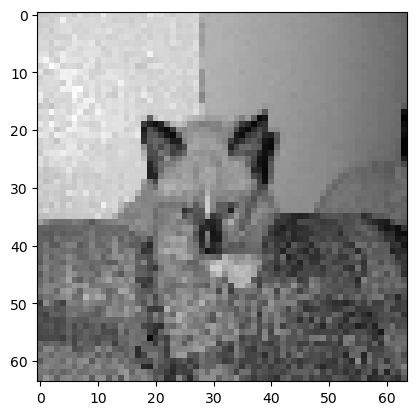

In [11]:
plt.imshow(sample_image, cmap=plt.cm.gray)

Run H.O.G. on the grayscale image to see what it will look like.

H.O.G. stands for Histogram of Oriented Gradients. It uses the gradient orientation of the localized regions of an image and generates a histogram for each localized region.


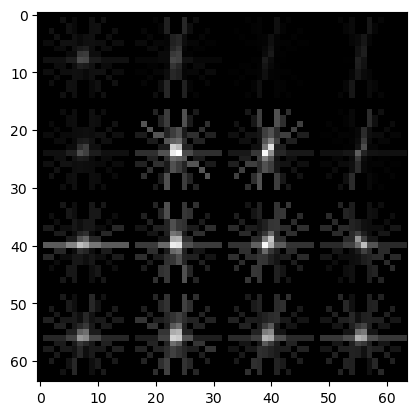

In [12]:
## when we run H.O.G., it returns an array of features and the image/output it produced
## the featurre is what we use to train the SVM model
sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## lets look at what the H.O.G. feature looks like
plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


Initiate a location for saving loaded images:


In [13]:
image_paths = list(paths.list_images('images'))
train_images = []
train_labels = []
class_object = annotations['labels']

Use the function on the image path:


In [14]:
load_images(image_paths)

Create an array of the images and use the <code>np.vstack</code> to vertically stack arrays for wrangling.


In [15]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

We will <code>reshape</code> the array to <code>(label size, 1)</code>. The array will look like this: <code>\[\[1], \[0], ..., \[0]]</code></p>


In [16]:
labels_array = np.array(train_labels)

In [17]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

Concatenate the images and labels:


In [18]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

Divide the data into a training and test set:


In [19]:
percentage = 75
partition = int(len(train_df)*percentage/100)

In [20]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

## Hyperparameters


The kernel type to be used is a hyperparameter. The most common kernels are <code>RBF</code>, <code>poly</code>, or <code>sigmoid</code>. You can also create your own kernel.

<code>C</code> behaves as a regularization parameter in the SVM. The <code>C</code> parameter trades off correct classification of the training examples against the maximization of the decision function’s margin. For larger values of <code>C</code>, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower <code>C</code> will encourage a larger margin, therefore a simpler decision function at the cost of accuracy. We select C and the best kernel by using the validation data.


The  python dictionary <code>param_grid</code>  has different kernels and values of C. We can test them using the validation data.


In [21]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

<code>gamma</code> is a parameter of the RBF kernel and can be thought of as the spread of the kernel and, therefore, the decision region. Low values mean ‘far’ and high values mean ‘close’. The behaviour of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself. We create a Support Vector Classification object.


## Support Vector Machines


In [22]:
base_estimator = SVC(gamma='scale')

**We will train the model and try different kernels and parameter values using the function <code>GridSearchCV</code>. The resulting output will be the model that performs best on the validation data.**

In [23]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

{'C': 1, 'kernel': 'rbf'}
Accuracy: 0.7
0.4389684200286865


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:821: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


**A Quick Guide to the Confusion Matrix**


A confusion matrix is a performance measurement for a classification problem. It is a table with a combination of predicted and actual values. On the y-axis, we have the `True` label and on the x-axis we have the `Predicted` label. This example will focus on a binary classifier, i.e. a yes or no model.

<table>
  <tr>
    <td>&nbsp;</td>
    <td>Predicted: NO</td>
    <td>Predicted: YES</td>
  </tr>
  <tr>
    <td>True: NO</td>
    <td>30</td>
    <td>30</td>
  </tr>
  <tr>
    <td>True: YES</td>
    <td>10</td>
    <td>50</td>
  </tr>
</table>

In this matrix, we can see that there are two classes. For example, if we were predicting if an image is a hotdog, "yes" will be that it is a hotdog and "no" will be that it is not a hotdog. We have 120 predictions and out of those times, the classifier predicted "yes" 80 times and "no" 40 times but really, there were 60 "yes"s and 60 "no"s.

When we talk about confusion matrix, we talk about a few terms:

*   True Positive (TP): Our model predicted "yes", and it was actually "yes"
*   True Negative (TN): Our model predicted "no", and it was actually "no"
*   False Positive (FP): Our model predicted "yes", but it was actually "no"
*   False Negative (FN): Our model predicted "no", but it was actually "yes"

Let's look at it in the context of our example:

<table>
  <tr>
    <td>&nbsp;</td>
    <td>Predicted: NO</td>
    <td>Predicted: YES</td>
  </tr>
  <tr>
    <td>True: NO</td>
    <td>TN = 30</td>
    <td>FP = 30</td>
    <td>60</td>
  </tr>
  <tr>
    <td>True: YES</td>
    <td>FN = 10</td>
    <td>TP = 50</td>
    <td>60</td>
  </tr>
  <tr>
    <td>&nbsp;</td>
    <td>40</td>
    <td>80</td>
  </tr>
</table>

**Accuracy** is the number the model got right over the total number of predictions. This is (TP+TN)/Total Number of Predictions.


Get Confusion Matrix for SVM results:


In [24]:
label_names = [0, 1]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

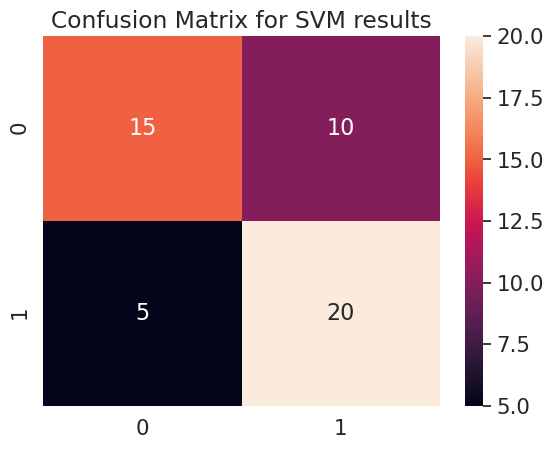

In [25]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

## Let's Report Our Results Back to CV Studio


In [26]:
parameters = {
    'best_params': best_parameters
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy=accuracy_score(y_test, y_pred))

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


In [27]:
# Save the SVM model to a file
joblib.dump(svm.best_estimator_, 'svm.joblib')

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/nump

['svm.joblib']

In [28]:
# Now let's save the model back to CV Studio
result = cvstudioClient.uploadModel('svm.joblib', {'svm_best': svm.best_estimator_})

File Uploaded


<h3>Training Run: Use SVM image classifier</h3>

Now that training is done, you can use your model for predictions. As your recall Support  Vector Machines (SVM) are supervised learning models used for classification. We will be using SVM to classify images.

You will upload your own image and classify using the model from the previous section.

## Objectives

<ul>
    <li>This tool contains the following sections:
        <ul>
            <li>Import Libraries </li>
            <li>Load saved SVM model </li>
            <li>Use the best parameters of <code>C, gamma and the Kernel</code></li>
            <li>Upload your own image and test the model </li>
        </ul>
    </li>
</ul>

***

## Import Important Libraries and Define Auxilary Functions


In [29]:
import numpy as np
import matplotlib.pyplot as plt

Libraries for image pre-processing and classification:

In [30]:
import cv2
from sklearn.externals import joblib
from skimage.feature import hog

Libraries for OS and Cloud:

In [31]:
import os
from skillsnetwork import cvstudio

## Set Up CV Studio Client, Get the Model and Annotations

We will load the model from the training run.

In [32]:
# Initialize the CV Studio Client
# cvstudioClient = cvstudio.CVStudio()

Get the annotations from CV Studio:

In [33]:
#annotations = cvstudioClient.get_annotations()

Download and load the saved model:

In [34]:
model_details = cvstudioClient.downloadModel()

In [35]:
pkl_filename = model_details['filename']

In [36]:
svm = joblib.load(pkl_filename) 

Upload your image, and see if your image will be correctly classified

In [37]:
cv2.imread("anothercar.jpg")

After importing your image, use the function <code>run_svm</code> to classify the object in your image.

In [38]:
def run_svm(image):
    ## show the original image
    orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(orig_image)
    plt.show()
    print('\n')
    ## convert the image into a numpy array
    image = np.array(image).astype('uint8')
    ## resize the image to a size of choice
    image = cv2.resize(image, (64, 64))
    ## convert to grayscale to reduce the information in the picture
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ## extract H.O.G features
    hog_features, hog_image = hog(grey_image,
                          visualize=True,
                          block_norm='L2-Hys',
                          pixels_per_cell=(16, 16))
    ## convert the H.O.G features into a numpy array
    image_array = np.array(hog_features)
    ## reshape the array
    image_array = image_array.reshape(1, -1)
    ## make a prediction
    svm_pred = svm.predict(image_array)
    ## print the classifier
    print('Your image was classified as a ' + str(annotations['labels'][int(svm_pred[0])]))    

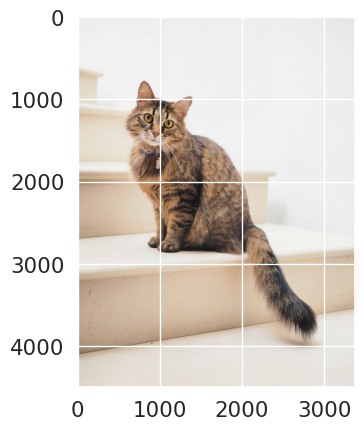



Your image was classified as a cat


In [39]:
my_image = cv2.imread("another_cat.jpg")
run_svm(my_image)

# Authors' rights

Machine Learning with Python course by IBM on Coursera: https://www.coursera.org/learn/machine-learning-with-python/

Completed and modified by Mathilde Marie Duville as part of the IBM Artificial Intelligence Engineering Professional Certificate and corresponding IBM badges. Please, follow the subsequent links to confirm the accreditation:

https://www.coursera.org/account/accomplishments/professional-cert/KSLW773DAATP?utm_source=link&utm_medium=certificate&utm_content=cert_image&utm_campaign=sharing_cta&utm_product=prof

https://www.credly.com/users/mathilde-marie-duville/badges

-------------------------------------------------------------------------------------------------------------------------------------------

Author:[Aije Egwaikhide](https://www.linkedin.com/in/aije-egwaikhide/?utm_medium=Exinfluencer\&utm_source=Exinfluencer\&utm_content=000026UJ\&utm_term=10006555\&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01) is a Data Scientist at IBM who holds a degree in Economics and Statistics from the University of Manitoba and a Post-grad in Business Analytics from St. Lawrence College, Kingston. She is currently pursuing her Masters in Management Analytics at Queens University. She is part of the IBM Developer Skills Network group where she brings her real-world experience to the courses she creates.

<h2>Change Log</h2>

### Training part: 

<table>
    <tr>
        <th>Date (YYYY-MM-DD)</th>
        <th>Version</th>
        <th>Changed By</th>
        <th>Change Description</th>
    </tr>
    <tr>
        <td>2021-05-25</td>
        <td>1.2</td>
        <td>Kathy</td>
        <td>Modified multiple areas</td>
    </tr>
    <tr>
        <td>2021-05-25</td>
        <td>1.2</td>
        <td>Yasmine</td>
        <td>Modified multiple areas</td>
    </tr>
     <tr>
        <td>2021-04-10</td>
        <td>1.1</td>
        <td>Aije</td>
        <td>Fixed grammatical errors</td>
    </tr>
    <tr>
        <td>2021-04-09</td>
        <td>1.0</td>
        <td>Aije</td>
        <td>Updated to new template</td>
    </tr>
    <tr>
        <td>2021-02-24</td>
        <td>0.1</td>
        <td>Aije</td>
        <td>Created original version of the lab</td>
    </tr>
</table>

### Test part:

<table>
    <tr>
        <th>Date (YYYY-MM-DD)</th>
        <th>Version</th>
        <th>Changed By</th>
        <th>Change Description</th>
    </tr>
    <tr>
        <td>2021-04-10</td>
        <td>1.1</td>
        <td>Aije</td>
        <td>Fixed grammatical errors and made comments headings</td>
    </tr>
    <tr>
        <td>2021-04-09</td>
        <td>1.0</td>
        <td>Aije</td>
        <td>Updated to new template</td>
    </tr>
    <tr>
        <td>2021-04-01</td>
        <td>0.2</td>
        <td>Aije</td>
        <td>Updated notebook to only test model</td>
    </tr>
    <tr>
        <td>2021-02-24</td>
        <td>0.1</td>
        <td>Aije</td>
        <td>Created original version of the lab</td>
    </tr>
</table>

Copyright © 2021 IBM Corporation. All rights reserved.
